In [3]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
import pandas as pd
import glob



# path = '2020'  
csv_files = glob.glob('British Grand Prix/*.csv', recursive= True) # ALL csv in the folder

# List 
dfs = []

# Iterate through the list of files
for filename in csv_files:
    df = pd.read_csv(filename)
    dfs.append(df)

# Concatenate all the dataframes in the list into a single dataframe
df = pd.concat(dfs, ignore_index=True)





# Convert time columns to seconds
time_columns = ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']
for col in time_columns:
    df[col] = pd.to_timedelta(df[col]).dt.total_seconds()

# Convert binary columns to integer type
df['Rainfall'] = df['Rainfall'].astype(int)
df['FreshTyre'] = df['FreshTyre'].astype(int)
df['IsAccurate'] = df['IsAccurate'].astype(int)


# Categorize weather condition based on centroid values of Kmeans clustering
def categorize_weather(row):
    if row['Rainfall'] > 0:
        return 'Rainy'
    elif row['AirTemp'] > 28.43213126:
        return 'high'
    elif row['AirTemp'] > 21.31279265:
        return 'medium'
    elif row['AirTemp'] > 12.84901403:
        return 'low'
    else:
        return 'very_low'

df['Weather_Category'] = df.apply(categorize_weather, axis=1)
df['Original_Weather_Category'] = df['Weather_Category']
df = pd.get_dummies(df, columns=['Weather_Category'])


# Keep the original Driver and Circuit for EDA
df['Original_Driver'] = df['Driver']

# Create Track temperature category based on the result of Kmeans clustering 
df['TrackTemp_Cat'] = pd.cut(df['TrackTemp'], bins=[0, 18.96764999, 27.87457484, 35.04425766, 41.75142602, 50.51006013], labels=['VERY_LOW', 'Low', 'Medium', 'Warm', 'High'])
df['Original_TrackTemp_Cat'] = df['TrackTemp_Cat']
df = pd.get_dummies(df, columns=['TrackTemp_Cat'])


#Feature Engineering with weather condition features
df['TrackConditionIndex'] = (df['AirTemp'] + df['TrackTemp'] + df['Humidity'] + df['Pressure'] +
                             df['WindSpeed'] + df['Rainfall']) / 6


# One-hot encoding
df = pd.get_dummies(df, columns=['Driver', 'Compound', 'Team','TrackStatus'])

# Drop irrelevant columns
columns_to_drop = ['Time', 'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
                   'PitOutTime', 'PitInTime', 'LapStartDate', 'Deleted', 'DeletedReason', 'FastF1Generated',
                   'IsPersonalBest', 'Sector3Time','LapStartTime','Sector2Time','Sector1Time']
df.drop(columns=columns_to_drop, inplace=True)


# Select numerical values for scaling and imputation
numeric_features = ['Humidity', 'Pressure', 'WindDirection', 'WindSpeed','TrackTemp','AirTemp','Rainfall','SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST']

from fancyimpute import IterativeImputer as MICE

# Initialize the MICE imputer
mice_imputer = MICE(random_state=42)
# Apply MICE imputation specifically to numeric features
df[numeric_features] = mice_imputer.fit_transform(df[numeric_features])



## Separate Rainy / dry days ##
# 1. Separate LapTime as dry or wet(rainy) condition ( since lapTime of rainy day would be recognized as outliers)
# 2. Remove Outliers for dry condition LapTime
# 3. Build Combined LapTime df (Outliers for dry days are deleted)

# Flag for rainy conditions
df['IsRainy'] = df['Rainfall'].apply(lambda x: 1 if x > 0 else 0)

# Separate dataframes for dry and wet conditions
df_dry = df[df['IsRainy'] == 0]
df_wet = df[df['IsRainy'] == 1]

# Remove Outliers for dry days using the IQR method that effective to removes extreme outliers
Q1_dry = df_dry['LapTime'].quantile(0.25)
Q3_dry = df_dry['LapTime'].quantile(0.75)
IQR_dry = Q3_dry - Q1_dry
lower_bound_dry = Q1_dry - 1.5 * IQR_dry
upper_bound_dry = Q3_dry + 1.5 * IQR_dry
df_dry_filtered = df_dry[(df_dry['LapTime'] >= lower_bound_dry) & (df_dry['LapTime'] <= upper_bound_dry)]
df_dry_filtered = df_dry_filtered.copy()
df_wet = df_wet.copy()


# Combining the datasets after scaling
df_combined = pd.concat([df_dry_filtered, df_wet], ignore_index=True)
df_combined.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 72 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   LapTime                    682 non-null    float64 
 1   Position                   682 non-null    float64 
 2   DriverNumber               682 non-null    int64   
 3   LapNumber                  682 non-null    float64 
 4   Stint                      682 non-null    float64 
 5   SpeedI1                    682 non-null    float64 
 6   SpeedI2                    682 non-null    float64 
 7   SpeedFL                    682 non-null    float64 
 8   SpeedST                    682 non-null    float64 
 9   TyreLife                   682 non-null    float64 
 10  FreshTyre                  682 non-null    int64   
 11  IsAccurate                 682 non-null    int64   
 12  Encoded_Rainfall           682 non-null    int64   
 13  Circuit_Name               682 non-

/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


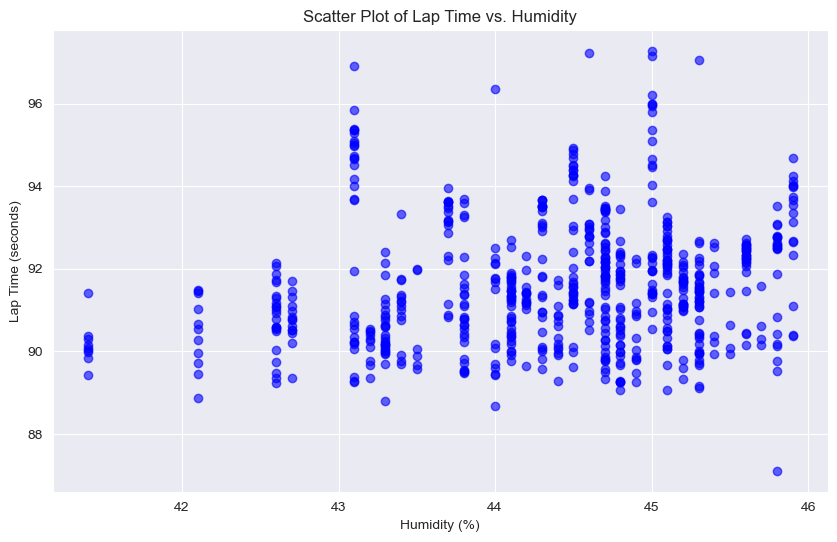

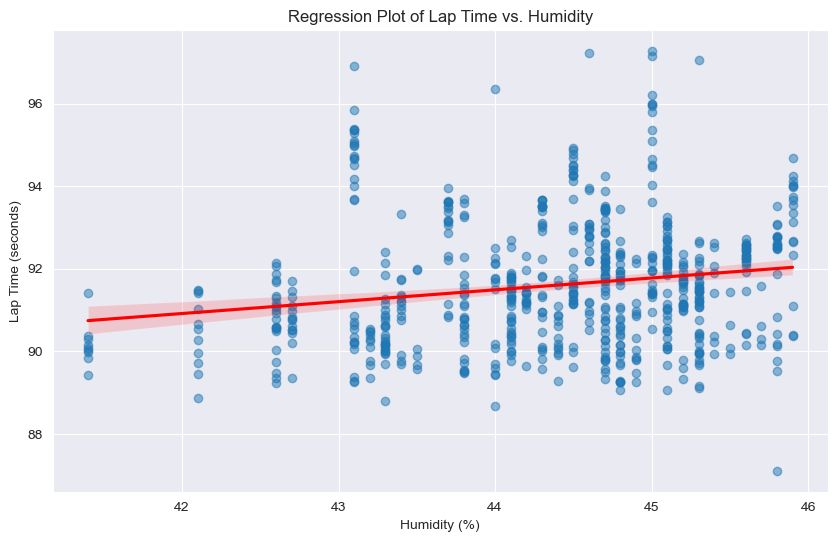

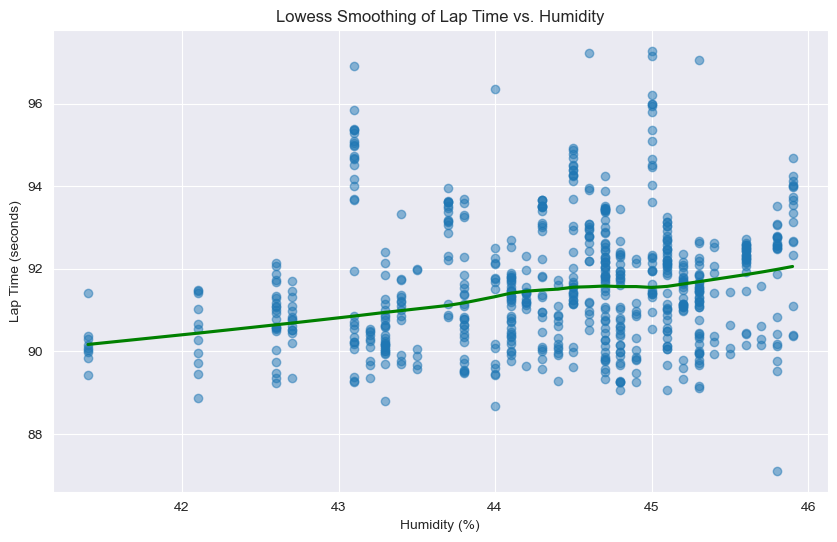

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
# Ensure 'df_combined' is loaded with 'LapTime' and 'Humidity' available
# Example: df_combined = pd.read_csv('path_to_your_data.csv')

# Scatter Plot to visualize the relationship between Humidity and LapTime
plt.figure(figsize=(10, 6))
plt.scatter(df_combined['Humidity'], df_combined['LapTime'], alpha=0.6, color='blue')
plt.title('Scatter Plot of Lap Time vs. Humidity')
plt.xlabel('Humidity (%)')
plt.ylabel('Lap Time (seconds)')
plt.grid(True)
plt.show()

# Regression Plot using seaborn to visualize the trend line along with scatter
plt.figure(figsize=(10, 6))
sns.regplot(x='Humidity', y='LapTime', data=df_combined, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title('Regression Plot of Lap Time vs. Humidity')
plt.xlabel('Humidity (%)')
plt.ylabel('Lap Time (seconds)')
plt.grid(True)
plt.show()

# Adding a lowess smoother to see a non-linear trend
plt.figure(figsize=(10, 6))
sns.regplot(x='Humidity', y='LapTime', data=df_combined, lowess=True, scatter_kws={'alpha':0.5}, line_kws={'color':'green'})
plt.title('Lowess Smoothing of Lap Time vs. Humidity')
plt.xlabel('Humidity (%)')
plt.ylabel('Lap Time (seconds)')
plt.grid(True)
plt.show()


/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/anaconda3/envs/COMS30035_labs/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


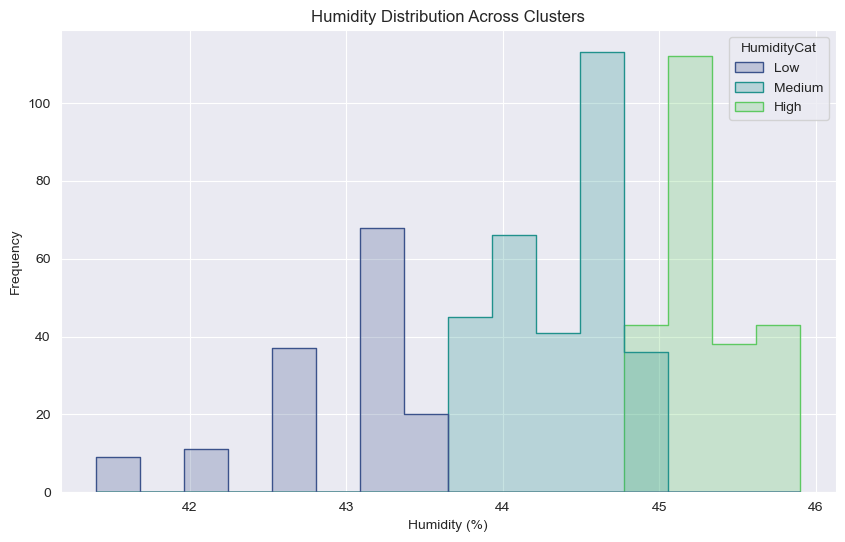

In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Prepare the data (assuming df_combined is already loaded and cleaned)
humidity_data = df_combined[['Humidity']].dropna()  # Ensuring there are no NaN values

# Step 2: Perform K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Choose 3 clusters for example
clusters = kmeans.fit_predict(humidity_data)

# Step 3: Create a new categorical feature
df_combined['HumidityCat'] = clusters

# Optionally add more descriptive labels based on the cluster characteristics
# For example, after inspecting cluster centers:
cluster_centers = kmeans.cluster_centers_
sorted_indices = np.argsort(cluster_centers.squeeze())  # Sort clusters by humidity level
labels = ['Low', 'Medium', 'High']
df_combined['HumidityCat'] = df_combined['HumidityCat'].map({idx: labels[i] for i, idx in enumerate(sorted_indices)})

# Step 4: Visualize the Results
# Plotting histograms for each cluster to visualize distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df_combined, x='Humidity', hue='HumidityCat', element='step', palette='viridis')
plt.title('Humidity Distribution Across Clusters')
plt.xlabel('Humidity (%)')
plt.ylabel('Frequency')
plt.show()


             count       mean       std     min       25%     50%     75%  \
HumidityCat                                                                 
High         236.0  91.816758  1.518008  87.097  90.86875  91.844  92.519   
Low          145.0  91.117200  1.638541  88.790  90.09600  90.619  91.417   
Medium       301.0  91.665326  1.423469  88.689  90.60900  91.548  92.632   

                max  
HumidityCat          
High         97.267  
Low          96.913  
Medium       97.226  


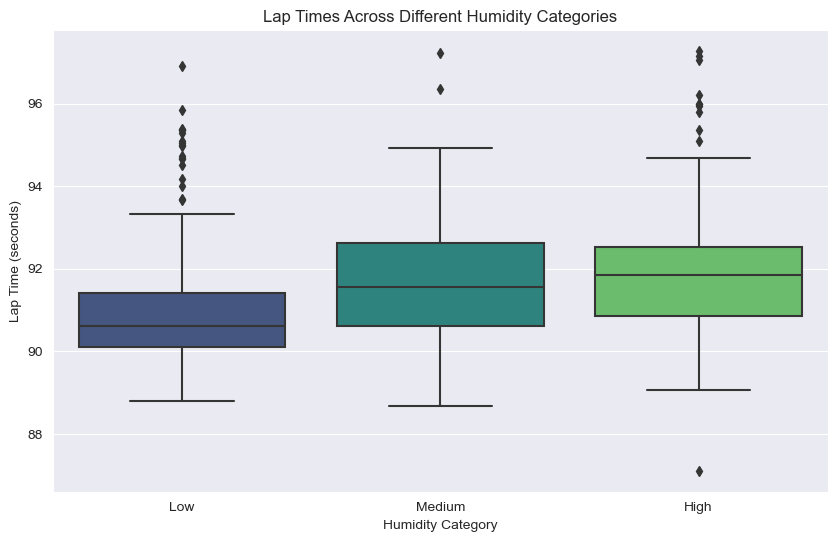

ANOVA result: F=10.20, p=0.0000
Statistically significant differences exist between the groups.


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import f_oneway

# Ensure the Humidity categorization is done as described previously
# Assuming 'HumidityCat' is already in df_combined from previous KMeans clustering

# Step 1: Statistical Summary
humidity_laptime_summary = df_combined.groupby('HumidityCat')['LapTime'].describe()
print(humidity_laptime_summary)

# Step 2: Box Plots
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_combined, x='HumidityCat', y='LapTime', palette='viridis')
plt.title('Lap Times Across Different Humidity Categories')
plt.xlabel('Humidity Category')
plt.ylabel('Lap Time (seconds)')
plt.show()

# Step 3: ANOVA Test
# Extract groups
group_data = [group['LapTime'].dropna() for name, group in df_combined.groupby('HumidityCat')]
anova_result = f_oneway(*group_data)
print(f"ANOVA result: F={anova_result.statistic:.2f}, p={anova_result.pvalue:.4f}")

# Interpreting the ANOVA result
if anova_result.pvalue < 0.05:
    print("Statistically significant differences exist between the groups.")
else:
    print("No statistically significant differences were found between the groups.")


SyntaxError: unterminated string literal (detected at line 34) (2407801768.py, line 34)